# 301 SRCapsNet PixelShuffle [Set5] -3

In [10]:
import numpy as np
import tensorflow as tf
import os, time
import scipy.ndimage
import scipy.misc
import matplotlib.pyplot as plt
from utils import imread, get_patches, imgset_read, imgresize, bicubic_upsize, PS, squash, safe_norm

slim = tf.contrib.slim
%matplotlib inline

In [11]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Dataset


In [12]:
hrImg_t=[]
for i in range(1,6):
    img = imread('images/Set5/HR/img_00'+str(i)+'.png', gray=True)
    hrImg_t.extend(get_patches(img, image_size=32, stride=14))
hrImg = np.array(hrImg_t)
#hrImg -= np.mean(hrImg)

hrImg = np.reshape(hrImg, [hrImg.shape[0], hrImg.shape[1], hrImg.shape[2], 1])
lrImg = imgresize(hrImg, scale=0.5)


# Networks

In [41]:
tf.reset_default_graph()
gpu = "/device:GPU:0"
cpu = '/cpu:0'

In [42]:
class SRCapsNet(object):
    def __init__(self, mode):
        
        self.mode = mode
        
        self.routing_iter = 2
        self.caps1_vec = 10
        self.caps1_num = 8*8*self.caps1_vec
        self.caps1_dim = 12
        self.caps2_vec = 10
        self.caps2_num = 8*8*self.caps2_vec
        self.caps2_dim = 12
        
        self.W_init = tf.random_normal(shape=(1, self.caps1_num, self.caps2_num, self.caps2_dim, self.caps1_dim), 
                                      stddev = 0.1, dtype=tf.float32, name='W_init')
        self.W = tf.Variable(self.W_init, name='w')
        
        print('The model is generated')
        
    def model(self, img):
        with slim.arg_scope([slim.conv2d],kernel_size=[5,5], stride=[1,1], activation_fn = tf.nn.leaky_relu,
                            padding='valid',weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):

            self.conv1 = slim.conv2d(inputs=img, num_outputs=256, scope='conv1')
            self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=self.caps1_vec*self.caps1_dim, stride=[1,1], scope='conv2')
        batch_size = tf.shape(img)[0]    
        self.caps1 = tf.reshape(self.conv2, [batch_size, self.caps1_num, self.caps1_dim], name='caps1_reshape')
        self.caps1_squash = squash(self.caps1, name='caps1_squash')


        self.W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1], name='W_tiled')

        self.caps1_expanded = tf.expand_dims(self.caps1_squash, -1, name='caps1_expanded')
        self.caps1_expanded2 = tf.expand_dims(self.caps1_expanded, 2, name='caps1_expanded2')
        self.caps1_tiled = tf.tile(self.caps1_expanded2, [1, 1, self.caps2_num, 1, 1], name='caps1_tiled')
        self.caps2_in = tf.matmul(self.W_tiled, self.caps1_tiled, name='caps2_in')
        self.b_ij = tf.zeros([batch_size, self.caps1_num, self.caps2_num, 1, 1], name='b_ij')
        for i in range(self.routing_iter):
            if i>0:
                self.b_ij = tf.add(self.b_ij, agreement)
            self.c_ij = tf.nn.softmax(self.b_ij, dim=2, name='c_ij')
            self.s_j = tf.reduce_sum(tf.multiply(self.c_ij, self.caps2_in), axis=1, keep_dims=True, name='s_j')
            self.v_j = squash(self.s_j, axis=-2, name='v_j')
            if i<self.routing_iter-1:
                self.v_j_tiled = tf.tile(self.v_j, [1, self.caps1_num, 1, 1, 1], name='v_j_tiled')
                agreement = tf.matmul(self.caps2_in, self.v_j_tiled, transpose_a=True, name='agreement')

        self.caps2_out = self.v_j
        self.caps2_reshape = tf.reshape(self.caps2_out, [-1,8,8,self.caps2_vec * self.caps2_dim], name='caps2_reshape')
        with slim.arg_scope([slim.conv2d],kernel_size=[3,3], stride=[1,1], activation_fn = tf.nn.leaky_relu,
                            padding='same',weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            self.conv3 = slim.conv2d(inputs=self.caps2_reshape, num_outputs=128, scope='conv3')
            self.conv4 = slim.conv2d(inputs=self.caps2_reshape, num_outputs=16, scope='conv4', activation_fn=tf.nn.sigmoid)
        #self.for_PS = tf.reshape(self.fc3, [-1, 14, 14, 1])

        self.out_layer = PS(self.conv4, 4, False)
        #self.conv3 = slim.conv2d(inputs=self.caps2_reshape, num_outputs=12, scope='conv3', activation_fn=None)
        #self.out_layer = PS(self.conv3, 2, True)

        out = self.out_layer
        return out
    
    def loss(self, SR, HR):
        loss = tf.reduce_mean(tf.square(SR - HR), name='loss')
        return loss
    
  


    def build(self):
        if self.mode == 'bicubic':
            self.LRImg = tf.placeholder(tf.float32, [None, 32, 32, 1], 'LRImgBicubic')
        elif self.mode == 'pixelshuffle':
            self.LRImg = tf.placeholder(tf.float32, [None, 16, 16, 1], 'LRImgPixelShuffle')
        else:
            print ('undefined mode')
        self.HRImg = tf.placeholder(tf.float32, [None, 32, 32, 1], 'HRImg')
        self.SRImg = self.model(self.LRImg)
        self.LOSS = self.loss(self.SRImg, self.HRImg)
    

        
        self.Fullinput = tf.placeholder(tf.float32, [None, 256,256,1])
        self.FullImg = self.model(self.Fullinput)

In [43]:
with tf.device(device):
    
    model = SRCapsNet('pixelshuffle')
    model.build()
    lr = tf.placeholder(tf.float32, shape=[])
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(model.LOSS)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config) 
    sess.run(tf.global_variables_initializer())

t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The model is generated
---------
Variables: name (type shape) [size]
---------
w:0 (float32_ref 1x640x640x12x12) [58982400, bytes: 235929600]
conv1/weights:0 (float32_ref 5x5x1x256) [6400, bytes: 25600]
conv1/biases:0 (float32_ref 256) [256, bytes: 1024]
conv2/weights:0 (float32_ref 5x5x256x120) [768000, bytes: 3072000]
conv2/biases:0 (float32_ref 120) [120, bytes: 480]
conv3/weights:0 (float32_ref 3x3x120x128) [138240, bytes: 552960]
conv3/biases:0 (float32_ref 128) [128, bytes: 512]
conv4/weights:0 (float32_ref 3x3x120x16) [17280, bytes: 69120]
conv4/biases:0 (float32_ref 16) [16, bytes: 64]
Total size of variables: 59912840
Total bytes of variables: 239651360


(59912840, 239651360)

In [44]:
train_path='images/train_bicubic_x2/'
label_path='images/train_HR/'

In [45]:
batch_size = 8
total_iter = int(hrImg.shape[0]/batch_size)
epoch_size=100
learning_rate = 1e-4

In [47]:
for epoch in range(epoch_size):
    avg_psnr = 0
    cnt = 0
    start_time=time.time()
    for i in range(total_iter):
        index = np.random.choice(hrImg.shape[0], batch_size, replace=False)
        HRImg = hrImg[index]
        LRImg = lrImg[index]

        _, loss = sess.run([optm, model.LOSS], feed_dict={model.LRImg:LRImg, model.HRImg:HRImg, lr:learning_rate})

        psnr = 20*np.log10(1./(np.sqrt(loss)))
        if psnr==psnr:  #check NaN
            avg_psnr += psnr
            cnt+=1

        print ("\ri: {}/{} ({:.1f}%) psnr: {:.5f}".format(i, total_iter, i*100/total_iter, psnr), end="")

    if epoch%30==29:
        learning_rate*=0.5
    print ('\repoch: %3d, avg_PSNR: %4f, time for epoch: %.2f' %(epoch, avg_psnr/cnt, time.time()-start_time))

    #mg = sess.run(model.out_layer, feed_dict={LRImg: train_image})
    #or j in range(img.shape[0]):
    #   imsave(img[j,:,:,0], 'results/srcnn'+str(j).zfill(4)+'.png')
    #   imsave(train_image[j,:,:,0], 'results/interpol_'+str(j).zfill(4)+'.png')



epoch:   0, avg_PSNR: 23.618395, time for epoch: 496.98
epoch:   1, avg_PSNR: 23.685250, time for epoch: 495.63
epoch:   2, avg_PSNR: 23.615307, time for epoch: 498.56
epoch:   3, avg_PSNR: 23.599743, time for epoch: 499.08
epoch:   4, avg_PSNR: 23.560478, time for epoch: 496.92
epoch:   5, avg_PSNR: 23.786357, time for epoch: 494.52
epoch:   6, avg_PSNR: 23.486677, time for epoch: 490.48
epoch:   7, avg_PSNR: 23.799793, time for epoch: 492.67
epoch:   8, avg_PSNR: 23.583215, time for epoch: 492.14
epoch:   9, avg_PSNR: 23.557344, time for epoch: 490.26
epoch:  10, avg_PSNR: 23.724823, time for epoch: 490.92
epoch:  11, avg_PSNR: 23.735549, time for epoch: 492.46
epoch:  12, avg_PSNR: 23.595917, time for epoch: 490.23
epoch:  13, avg_PSNR: 23.632928, time for epoch: 490.04
epoch:  14, avg_PSNR: 23.690420, time for epoch: 490.83
epoch:  15, avg_PSNR: 23.683311, time for epoch: 491.24
epoch:  16, avg_PSNR: 23.882916, time for epoch: 490.04
epoch:  17, avg_PSNR: 23.685967, time for epoch:

In [10]:
saver=tf.train.Saver()

In [38]:

saver.save(sess, 'checkpoints/CVLab/Set5/x2_psnr_33-12')

'checkpoints/CVLab/Set5/x2_psnr_33-12'

In [48]:
saver.restore(sess,'checkpoints/CVLab/Set5/x2_psnr_33-12')

INFO:tensorflow:Restoring parameters from checkpoints/CVLab/Set5/x2_psnr_33-12


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.

In [19]:
fullimage = np.reshape(imread('images/Set5/HR/img_001.png', gray=True), [1,512,512,1])
fulllrimage = imgresize(fullimage, 0.5)
fulllrimage = np.concatenate([fulllrimage, fulllrimage], axis=0)
outimage = sess.run(model.FullImg, feed_dict={model.Fullinput:fulllrimage})
outimage.shape

InvalidArgumentError: Input to reshape is a tensor with 14760960 values, but the requested shape has 15360
	 [[Node: caps1_reshape_1 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2_1/LeakyRelu/Maximum-0-0-TransposeNCHWToNHWC-LayoutOptimizer, caps1_reshape_1/shape)]]

Caused by op 'caps1_reshape_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-8923c48e747a>", line 4, in <module>
    model.build()
  File "<ipython-input-14-d9cfecd7b8b3>", line 86, in build
    self.FullImg = self.model(self.Fullinput)
  File "<ipython-input-14-d9cfecd7b8b3>", line 28, in model
    self.caps1 = tf.reshape(self.conv2, [batch_size, self.caps1_num, self.caps1_dim], name='caps1_reshape')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 5782, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 14760960 values, but the requested shape has 15360
	 [[Node: caps1_reshape_1 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2_1/LeakyRelu/Maximum-0-0-TransposeNCHWToNHWC-LayoutOptimizer, caps1_reshape_1/shape)]]


In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(fullimage[0,:,:,0], cmap='gray')

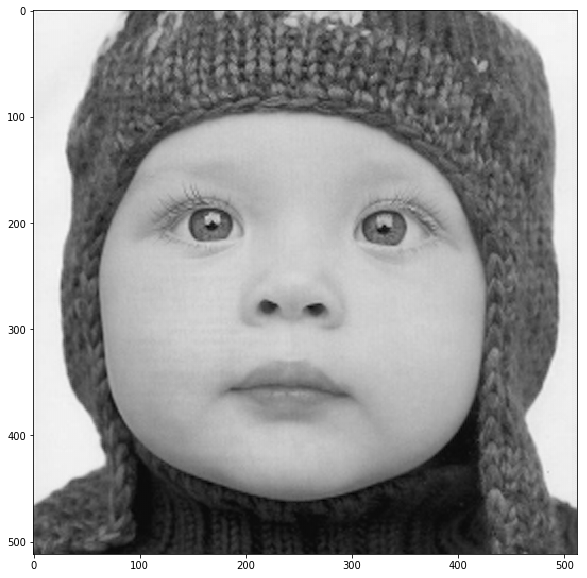

In [43]:
plt.figure(figsize=[10,10])
plt.imshow(outimage[0,:,:,0], cmap='gray')

In [44]:
20*np.log10(1./(np.sqrt(np.mean(np.square(outimage-fullimage)))))

35.69221397400337

In [21]:
SRImg = sess.run(model.SRImg, feed_dict={model.LRImg:LRImg})
SRImg.shape

(8, 32, 32, 1)

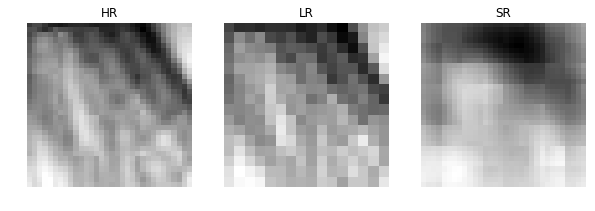

In [27]:
plt.figure(figsize=[10,10])
plt.subplot(1,3,1)
plt.imshow(HRImg[4,:,:,0], cmap='gray')
plt.axis('off')
plt.title('HR')
plt.subplot(1,3,2)
plt.imshow(LRImg[4,:,:,0], cmap='gray')
plt.axis('off')
plt.title('LR')
plt.subplot(1,3,3)
plt.imshow(SRImg[4,:,:,0], cmap='gray')
plt.axis('off')
plt.title('SR')